# Grid Metrics
Most modern circulation models discretize the partial differential equations needed to simulate the earth system on a logically rectangular grid. This means the grid for a single time step can be represented as a 3-dimensional array of cells. Even for more complex grid geometries like [here](https://xgcm.readthedocs.io/en/latest/grid_topology.html), subdomains are usually organized in this manner. A noteable exception are models with unstructured grids [example](https://en.wikipedia.org/wiki/Unstructured_grid), which currently cannot be processed with the datamodel of xarray and xgcm.

Our grid operators work on the logically rectangular grid of an ocean model, meaning that e.g. differences are evaluated on the 'neighboring' cells in either direction, but even though these cells are adjacent, cells can have different size and geometry.

In order to convert operators acting on the logically rectangular grid to physically meaningful output models need 'metrics' - information about the grid cell geometry in physical space.
In the case of a perfectly [rectangular cuboid](https://en.wikipedia.org/wiki/Cuboid), the only metrics needed would be three of the edge distances. All other distances can be reconstructed exactly. Most ocean models have however slightly distorted cells, due to the curvature of the earth. To accurately represent the volume of the cell we require more metrics. 

Each grid point has three kinds of fundamental metrics associated with it which differ in the number of described axes:

1. **Distances**: A distance is associated with a single axis (e.g. `('X',)`,`('Y',)` or `('Z',)`). Each distance describes the distance from the point to either face of the cell associated with the grid point. 
2. **Areas**: An area is associated with a pair of axes (e.g. `('X', 'Y')`, `('Y', 'Z')` and `('X', 'Z')`). Each grid point intersects three areas.
3. **Volume**: The cell volume is unique for each cell and associated with all three axes (`('X', 'Y', 'Z')`).

## Using metrics with xgcm
Once the user assigns the metrics (given as coordinates in most model output) to the `grid` object, xgcm is able to automatically select and apply these to calculate e.g. derivatives and integrals from model data. 

> *Note*: xgcm does not currently check for alignment of missing values between data and metrics. The user needs to check and mask values appropriately

In [ ]:
import xarray as xr
import numpy as np
from xgcm import Grid
import matplotlib.pyplot as plt
%matplotlib inline

/Users/tim/anaconda3/lib/python3.7/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/Users/tim/anaconda3/lib/python3.7/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [ ]:
# hack to make file name work with nbsphinx and binder
import os
fname = '../datasets/mitgcm_example_dataset_v2.nc'
if not os.path.exists(fname):
    fname = '../' + fname
    
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:  (XC: 90, XG: 90, YC: 40, YG: 40, Z: 15, Zl: 15, time: 1)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
    maskC    (Z, YC, XC) bool ...
    dyC      (YG, XC) float32 ...
    hFacC    (Z, YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    hFacS    (Z, YG, XC) float32 ...
    Depth    (YC, XC) float32 ...
  * YG       (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
  * Z        (Z) float32 -25.0 -85.0 -170.0 -290.0 ... -3575.0 -4190.0 -4855.0
    PHrefC   (Z) float32 ...
    dyG      (YC, XG) float32 ...
    rAw      (YC, XG) float32 ...
    drF      (Z) float32 ...
  * YC       (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 ... 66.0 70.0 74.0 78.0
    dxG      (YG, XC) float32 ...
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0
    iter     (time) int64 ...
    maskW    (Z, YC, XG) bool ...
  * Zl       (Zl) float32 0.0 -50.0 -120.0 -220.0 ... -3280.0 -3870.0 -4510.0
    rAs      (YG, XC) float3

For mitgcm output we need to first incorporate partial cell thicknesses into new metric coordinates

In [ ]:
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point

To assign the metrics, the user has to provide a dictionary with keys and entries corresponding to the spatial orientation of the metrics and a list of the appropriate variable names in the dataset. 

In [ ]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances 
    ('Y',): ['dyC', 'dyG'], # Y distances 
    ('Z',): ['drW', 'drS', 'drC'], # Z distances 
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas 
}
grid = Grid(ds, metrics=metrics)

## Grid aware integration

It is now possible to integrate over e.g. the Z axis with:

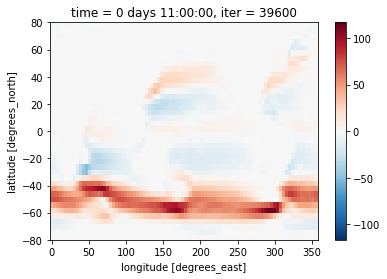

In [5]:
grid.integrate(ds.UVEL, 'Z').plot();

This is equivalent to doing `(ds.UVEL * ds.drW).sum('Z')`, with the advantage of not having to remember the name of the appropriate metric and the matching dimension. The only thing the user needs to input is the axis to integrate over.

In [6]:
a = grid.integrate(ds.UVEL, 'Z')
b = (ds.UVEL * ds.drW).sum('Z')
xr.testing.assert_equal(a, b)

We can do the exact same thing on a tracer field (which is located on a different grid point) by using the exact same syntax:

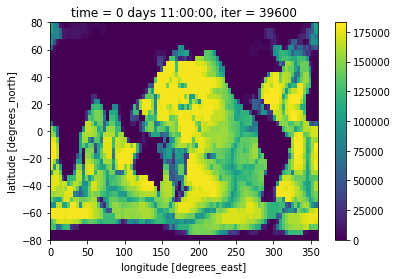

In [7]:
grid.integrate(ds.SALT, 'Z').plot();

It also works in two dimensions:

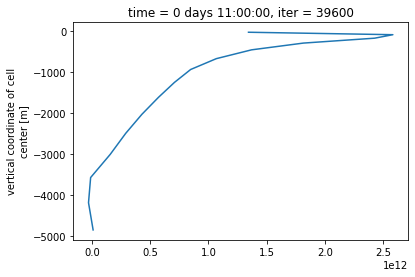

In [10]:
a = grid.integrate(ds.UVEL, ['X', 'Y'])
a.plot(y='Z')

# Equivalent to integrating over area
b = (ds.UVEL * ds.rAw).sum(['XG', 'YC'])
xr.testing.assert_equal(a, b)

And finally in 3 dimensions, this time using the salinity of the tracer cell:

In [11]:
grid.integrate(ds.UVEL, ['X', 'Y', 'Z'])

<xarray.DataArray (time: 1)>
array([2.367449e+15], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
    iter     (time) int64 ...

But wait, we did not provide a cell volume when setting up the `Grid`. What happened?

Whenever no matching metric is provided, xgcm will default to reconstruct it from the other available metrics, in this case the area and z distance of the tracer cell

In [12]:
a = grid.integrate(ds.SALT, ['X', 'Y', 'Z'])
b = (ds.SALT * ds.rA * ds.drC).sum(['XC', 'YC', 'Z'])
xr.testing.assert_allclose(a, b)

### Grid-aware (weighted) average

xgcm can also calcualate the weighted average along each axis and combinations of axes:

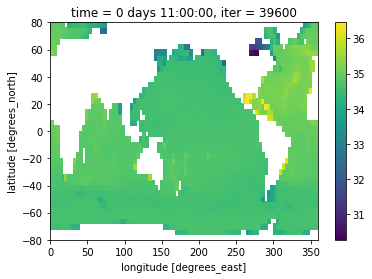

In [11]:
# depth mean salinity
grid.average(ds.SALT, ['Z']).plot()

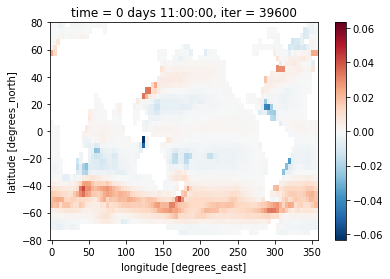

In [12]:
# depth mean zonal velocity
grid.average(ds.UVEL, ['Z']).plot()

This works with multiple dimensions as well:

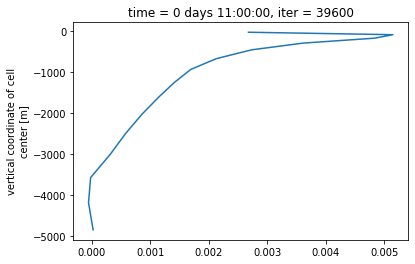

In [14]:
# horizontal average zonal velocity
grid.average(ds.UVEL, ['X','Y']).plot(y='Z')

In [15]:
# average salinity of the global ocean
# horizontal average zonal velocity
grid.average(ds.SALT, ['X','Y', 'Z'])

<xarray.DataArray (time: 1)>
array([34.73095], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
    iter     (time) int64 ...

### Cumulative integration

Using the metric-aware cumulative integration `cumint`, we can calculate the [barotropic transport streamfunction](https://xgcm.readthedocs.io/en/latest/example_mitgcm.html#Barotropic-Transport-Streamfunction) even easier and more intuitive in one line:

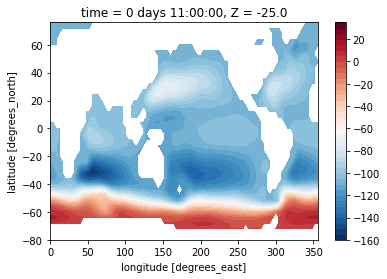

In [29]:
# the streamfunction is the cumulative integral of the vertically integrated zonal velocity along y
psi = grid.cumint(-grid.integrate(ds.UVEL,'Z'),'Y', boundary='fill')

maskZ = grid.interp(ds.hFacS, 'X').isel(Z=0)
(psi / 1e6).squeeze().where(maskZ).plot.contourf(levels=np.arange(-160, 40, 5))

## Computing derivatives



In a similar fashion to integration, xgcm uses `metrics` to compute derivatives. 
For this example we show vertical shear, i.e. the derivative of some quantity in the vertical.

At it's core, `derivative` is based on `diff`, which results in a shifts a data array 
to a new grid point, as shown
[here](https://xgcm.readthedocs.io/en/latest/grids.html#core-grid-operations-diff-interp-and-cumsum).
Because of this shifting, we need to either define new metrics which live at the right points on the grid, 
or first interpolate the desired quantities, anticipating the shift.
Here we choose the latter, and interpolate velocities and temperature onto the vertical cell faces of the grid 
cells.
The resulting quantities are in line with the vertical velocity `w`, which is shown in the vertical grid of the C 
grid [here](https://xgcm.readthedocs.io/en/latest/grids.html#general-concepts).

In [13]:
uvel_l = grid.interp(ds.UVEL,'Z')
vvel_l = grid.interp(ds.VVEL,'Z')
theta_l = grid.interp(ds.THETA,'Z')

The subscript "l" is used to denote a leftward shift on the vertical axis, following [this nomenclature](https://xgcm.readthedocs.io/en/latest/grids.html#axes-and-positions).

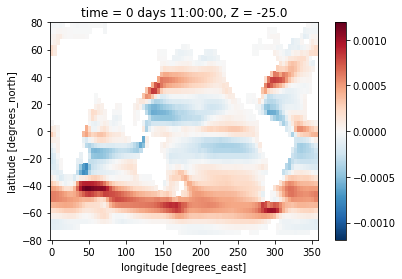

In [14]:
zonal_shear = grid.derivative(uvel_l,'Z')
zonal_shear.isel(Z=0).plot();

This shows zonal velocity shear in the top layer, and note that here we first interpolated from "Z"->"Zl" and 
the derivative operation shifted the result back from "Zl"->"Z".

In [15]:
print('1. ', ds.UVEL.dims)
print('2. ', uvel_l.dims)
print('3. ', zonal_shear.dims)

1.  ('time', 'Z', 'YC', 'XG')
2.  ('time', 'Zl', 'YC', 'XG')
3.  ('time', 'Z', 'YC', 'XG')


For reference, the vertical profiles of horizontal average of zonal velocity 
and zonal velocity shear are shown below.

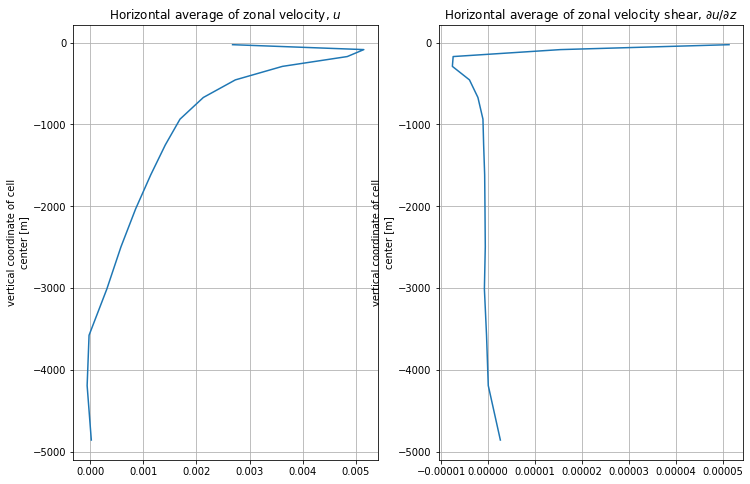

In [16]:
fig,axs = plt.subplots(1,2,figsize=(12,8))
titles=['Horizontal average of zonal velocity, $u$',
        'Horizontal average of zonal velocity shear, $\partial u/\partial z$']
for ax,fld,title in zip(axs,[ds.UVEL,zonal_shear],titles):
    
    # Only select non-land (a.k.a. wet) points
    fld = fld.where(ds.maskW).isel(time=0).copy()
    (grid.integrate(fld,['X','Y']) /
     grid.integrate(xr.ones_like(fld),['X','Y'])).plot(ax=ax,y='Z')
    ax.grid();
    ax.set_title(title);

The derivative operation shown above is equivalent to `grid.diff( uvel_l, 'Z' ) / ds.drW`.

In [17]:
expected_result = (grid.diff( uvel_l, 'Z') ) /ds.drW
xr.testing.assert_equal(zonal_shear, expected_result.reset_coords(drop=True))

Additionally, for meridional velocity and temperature in the top layer:

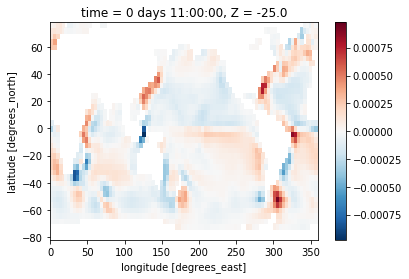

In [18]:
grid.derivative(vvel_l,'Z').isel(Z=0).plot();

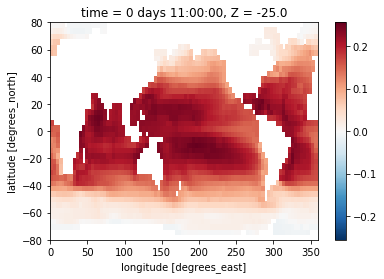

In [19]:
grid.derivative(theta_l,'Z').isel(Z=0).plot();

<div class="alert alert-info">

**Note:** The `.derivative` function performs a centered finite difference operation. 
Keep in mind that this is different from 
[finite volume differencing schemes](https://mitgcm.readthedocs.io/en/latest/algorithm/finitevol-meth.html) 
as used in many ocean models.
See [this section](https://xgcm.readthedocs.io/en/latest/example_mitgcm.html#Divergence) 
of documentation for some examples of how xgcm can be helpful in performing these operations.

</div>